In [20]:
import csv
import cv2
from os import path
import numpy as np
import matplotlib.pyplot as plt
# import pickle
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Dropout
from keras.layers.convolutional import Convolution2D, Cropping2D
from keras.layers.pooling import MaxPooling2D
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [21]:
def loadData(basePath):
    """ Load the images and steering angles from the basePath
        assuming the headline of the CSV file is removed (starting the image name)
    :param basepath: base path which contains the csv file and IMG folder
    :return: images, angles
    """
    lines = []
    with open(path.join(basePath,'driving_log.csv')) as f:
        content = csv.reader(f)
        for line in content:
            lines.append(line)

    return lines

In [24]:
def balance_data(samples, visulization_flag ,N=60, K=1,  bins=100):
    """ Crop the top part of the steering angle histogram, by removing some images belong to those steering angels

    :param images: images arrays
    :param angles: angles arrays which
    :param n:  The values of the histogram bins
    :param bins: The edges of the bins. Length nbins + 1
    :param K: maximum number of max bins to be cropped
    :param N: the max number of the images which will be used for the bin
    :return: images, angle
    """

    angles = []
    for line in samples:
        angles.append(float(line[3]))

    n, bins, patches = plt.hist(angles, bins=bins, color= 'orange', linewidth=0.1)
    angles = np.array(angles)
    n = np.array(n)

    idx = n.argsort()[-K:][::-1]    # find the largest K bins
    del_ind = []                    # collect the index which will be removed from the data
    for i in range(K):
        if n[idx[i]] > N:
            ind = np.where((bins[idx[i]]<=angles) & (angles<bins[idx[i]+1]))
            ind = np.ravel(ind)
            np.random.shuffle(ind)
            del_ind.extend(ind[:len(ind)-N])

    # angles = np.delete(angles,del_ind)
    balanced_samples = [v for i, v in enumerate(samples) if i not in del_ind]
    balanced_angles = np.delete(angles,del_ind)

    plt.subplot(1,2,2)
    plt.hist(balanced_angles, bins=bins, color= 'orange', linewidth=0.1)
    plt.title('modified histogram', fontsize=20)
    plt.xlabel('steering angle', fontsize=20)
    plt.ylabel('counts', fontsize=20)

    if visulization_flag:
        plt.figure
        plt.subplot(1,2,1)
        n, bins, patches = plt.hist(angles, bins=bins, color='orange', linewidth=0.1)
        plt.title('origin histogram', fontsize=20)
        plt.xlabel('steering angle', fontsize=20)
        plt.ylabel('counts', fontsize=20)
        plt.show()

        plt.figure
        aa = np.append(balanced_angles, -balanced_angles)
        bb = np.append(aa, aa)
        plt.hist(bb, bins=bins, color='orange', linewidth=0.1)
        plt.title('final histogram', fontsize=20)
        plt.xlabel('steering angle', fontsize=20)
        plt.ylabel('counts', fontsize=20)
        plt.show()

    return balanced_samples

In [25]:
def data_augmentation(images, angles):
    """ flip every image and change the blitheness of the image, then appended to the lists

    :param images: origin image
    :param angles: origin angles
    :return: added augmented images and their angles
    """
    augmented_images = []
    augmented_angles = []
    for image, angle in zip(images, angles):

        augmented_images.append(image)
        augmented_angles.append(angle)

        # flip
        flipped_image = cv2.flip(image,1)
        flipped_angle = -1.0 * angle
        augmented_images.append(flipped_image)
        augmented_angles.append(flipped_angle)

        # brightness changes
        image_b1 = brightness_change(image)
        image_b2 = brightness_change(flipped_image)

        # append images
        augmented_images.append(image_b1)
        augmented_angles.append(angle)
        augmented_images.append(image_b2)
        augmented_angles.append(flipped_angle)

    return augmented_images, augmented_angles

In [27]:
def network_model():
    """

    :return: designed network model
    """
    model = Sequential()
    model.add(Lambda(lambda x: x / 127.5 - 1., input_shape=(160,320,3)))
    model.add(Cropping2D(cropping=((70,25),(0,0))))
    model.add(Convolution2D(32, kernel_size=(3,3),activation='relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.1))
    model.add(Convolution2D(64, kernel_size=(3,3),activation='relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.1))
    model.add(Convolution2D(128, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D())
    model.add(Convolution2D(256, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D())

    model.add(Flatten())
    model.add(Dense(120))
    model.add(Dense(20))
    model.add(Dense(1))
    return model

In [28]:
def generator(samples, train_flag, batch_size=32):
    """

    """
    num_samples = len(samples)
    correction = 0.2  # correction angle used for the left and right images

    while 1:  # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []

            for line in batch_samples:
                angle = float(line[3])
                c_imagePath = line[0].replace(" ", "")
                c_image = cv2.imread(c_imagePath)
                images.append(c_image)
                angles.append(angle)

                if train_flag:  # only add left and right images for training data (not for validation)
                    l_imagePath = line[1].replace(" ", "")
                    r_imagePath = line[2].replace(" ", "")
                    l_image = cv2.imread(l_imagePath)
                    r_image = cv2.imread(r_imagePath)

                    images.append(l_image)
                    angles.append(angle + correction)
                    images.append(r_image)
                    angles.append(angle - correction)

            # flip image and change the brightness, for each input image, returns other 3 augmented images
            augmented_images, augmented_angles = data_augmentation(images, angles)

            X_train = np.array(augmented_images)
            y_train = np.array(augmented_angles)
            yield shuffle(X_train, y_train)

In [29]:
# load the csv file
basePath = '../self-driving-car'
print('loading the data...')
samples = loadData(basePath)

loading the data...


/tmp/ipykernel_230318/314774465.py:34: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,2)


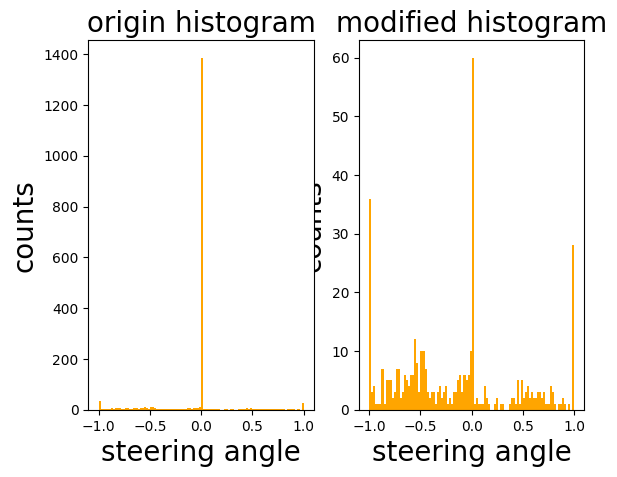

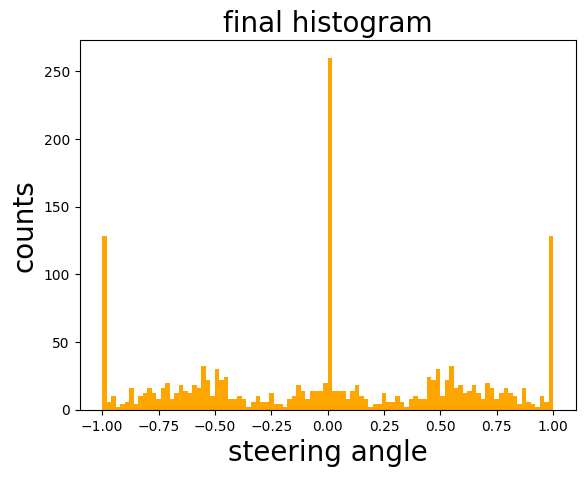

In [30]:
# balance the data with smooth the histogram of steering angles
samples = balance_data(samples, visulization_flag=True)

In [31]:
# split data into training and validation
train_samples, validation_samples = train_test_split(samples, test_size=0.3)

In [32]:
# compile and train the model using the generator function
train_generator = generator(train_samples, train_flag=True, batch_size=32)
validation_generator = generator(validation_samples, train_flag=False, batch_size=32)

In [33]:
# define the network model
model = network_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_2 (Lambda)           (None, 160, 320, 3)       0         
                                                                 
 cropping2d_2 (Cropping2D)   (None, 65, 320, 3)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 63, 318, 32)       896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 31, 159, 32)      0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 31, 159, 32)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 29, 157, 64)       18496     
                                                      

In [35]:
nbEpoch = 4
model.compile(loss='mse', optimizer='adam')

history = model.fit_generator(train_generator,
                              steps_per_epoch=12,
                              epochs=nbEpoch,
                              validation_data=validation_generator,
                              validation_steps=len(validation_samples))

/tmp/ipykernel_230318/3101426582.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


KeyboardInterrupt: 

In [ ]:
model.save('model.h5')